In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [6]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score
)
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [10]:
# -----------------------------
# 1. Load Dataset
# -----------------------------
DATA = "/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA)
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [14]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [15]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'] * df['tenure'])
df.drop(columns=['customerID'], inplace=True)
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

y = df['Churn']
X = df.drop(columns=['Churn'])

In [17]:
# -----------------------------
# 2. Preprocessing
# -----------------------------
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

In [18]:
# -----------------------------
# 3. Train/test split + SMOTE
# -----------------------------
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Train after SMOTE:", X_train_res.shape, np.bincount(y_train_res))

Train after SMOTE: (8278, 45) [4139 4139]


In [21]:
# -----------------------------
# 4. Helper Method: Evaluate + Visualize
# -----------------------------
metrics_summary = {}

def evaluate_model(model, X_train, y_train, X_test, y_test, name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    metrics_summary[name] = [acc, prec, rec, f1, roc_auc]

    print(f"\n=== {name} ===")
    print("Accuracy: %.4f\nPrecision: %.4f\nRecall: %.4f\nF1: %.4f\nROC_AUC: %.4f" %
          (acc, prec, rec, f1, roc_auc))
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"{name} — Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return model, y_proba


=== Logistic Regression (GridSearch) ===
Accuracy: 0.7374
Precision: 0.5034
Recall: 0.7941
F1: 0.6162
ROC_AUC: 0.8403
              precision    recall  f1-score   support

           0     0.9060    0.7169    0.8004      1035
           1     0.5034    0.7941    0.6162       374

    accuracy                         0.7374      1409
   macro avg     0.7047    0.7555    0.7083      1409
weighted avg     0.7991    0.7374    0.7515      1409



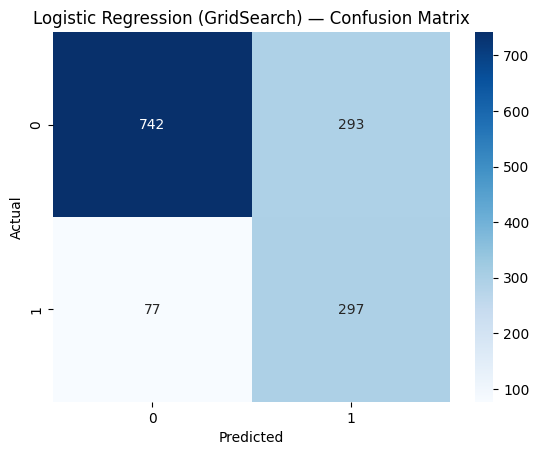

Best Logistic Regression Params: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


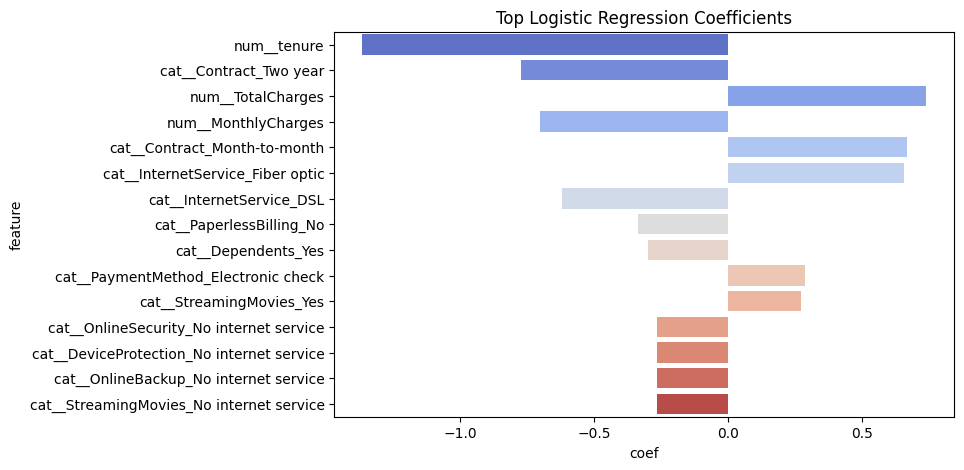

In [22]:
# -----------------------------
# 5. Logistic Regression (GridSearchCV)
# -----------------------------
log_param_grid = {
    'C': [0.01, 0.1, 1],
    'solver': ['liblinear','lbfgs'],
    'penalty': ['l2']
}
log_clf = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    log_param_grid, cv=3, scoring="roc_auc", n_jobs=-1
)
log_clf, log_proba = evaluate_model(log_clf, X_train_res, y_train_res, X_test, y_test, "Logistic Regression (GridSearch)")
print("Best Logistic Regression Params:", log_clf.best_params_)

# Top Logistic Coefficients
feature_names = preprocessor.get_feature_names_out()
coefs = log_clf.best_estimator_.coef_.ravel()
coef_df = pd.DataFrame({"feature":feature_names, "coef":coefs})
top_coef = coef_df.reindex(coef_df.coef.abs().sort_values(ascending=False).index)[:15]
plt.figure(figsize=(8,5))
sns.barplot(x="coef", y="feature", data=top_coef, palette="coolwarm")
plt.title("Top Logistic Regression Coefficients")
plt.show()


=== Decision Tree (GridSearch) ===
Accuracy: 0.7509
Precision: 0.5223
Recall: 0.7193
F1: 0.6052
ROC_AUC: 0.8179
              precision    recall  f1-score   support

           0     0.8826    0.7623    0.8180      1035
           1     0.5223    0.7193    0.6052       374

    accuracy                         0.7509      1409
   macro avg     0.7024    0.7408    0.7116      1409
weighted avg     0.7869    0.7509    0.7615      1409



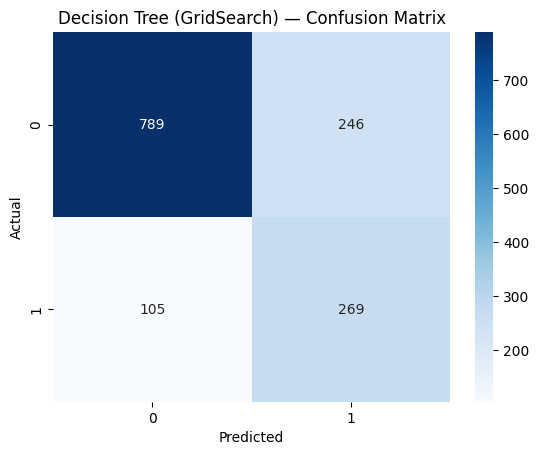

Best Decision Tree Params: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 10}


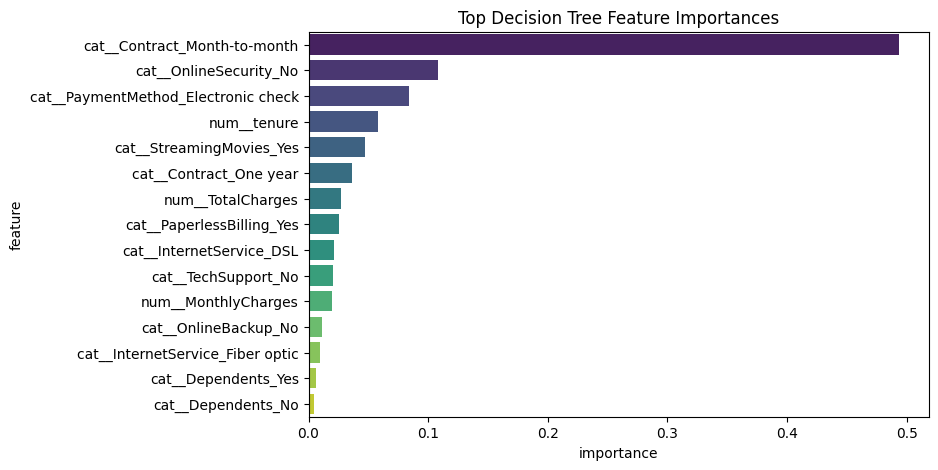

In [23]:
# -----------------------------
# 6. Decision Tree (GridSearchCV)
# -----------------------------
dt_param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 10],
    'criterion': ['gini', 'entropy']
}
dt_clf = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_param_grid, cv=3, scoring="roc_auc", n_jobs=-1
)
dt_clf, dt_proba = evaluate_model(dt_clf, X_train_res, y_train_res, X_test, y_test, "Decision Tree (GridSearch)")
print("Best Decision Tree Params:", dt_clf.best_params_)

# Decision Tree Feature Importances
importances = dt_clf.best_estimator_.feature_importances_
imp_df = pd.DataFrame({"feature":feature_names, "importance":importances})
top_imp = imp_df.sort_values("importance", ascending=False)[:15]
plt.figure(figsize=(8,5))
sns.barplot(x="importance", y="feature", data=top_imp, palette="viridis")
plt.title("Top Decision Tree Feature Importances")
plt.show()

E0000 00:00:1758562151.905408     108 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758562151.912815     108 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1758562151.934246     110 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758562151.946462     110 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1758562151.999059     107 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758562152.011161     107 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register fact


=== Neural Net (GridSearch) ===
Accuracy: 0.7431
Precision: 0.5105
Recall: 0.7834
F1: 0.6181
ROC_AUC: 0.8262
              precision    recall  f1-score   support

           0     0.9030    0.7285    0.8064      1035
           1     0.5105    0.7834    0.6181       374

    accuracy                         0.7431      1409
   macro avg     0.7067    0.7560    0.7123      1409
weighted avg     0.7988    0.7431    0.7564      1409



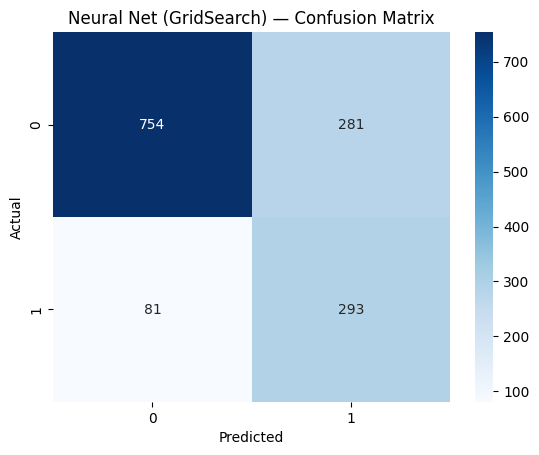

Best Neural Net Params: {'batch_size': 32, 'epochs': 20, 'model__dropout_rate': 0.3, 'model__hidden_units': 64, 'model__learning_rate': 0.001, 'model__optimizer': 'adam'}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


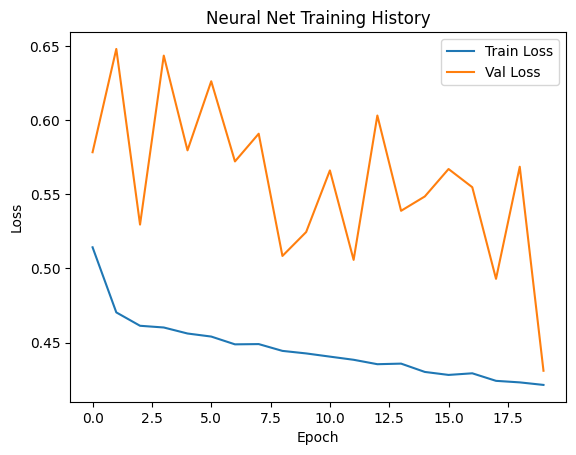

In [24]:
# -----------------------------
# 7. Neural Net (Keras + GridSearchCV)
# -----------------------------
input_dim = X_train_res.shape[1]

def build_nn(hidden_units=64, dropout_rate=0.3, optimizer="adam", learning_rate=0.001):
    model = Sequential()
    model.add(Dense(hidden_units, activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_units//2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    if optimizer=="adam":
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["AUC"])
    return model

keras_clf = KerasClassifier(model=build_nn, verbose=0)

nn_param_grid = {
    "model__hidden_units": [64],
    "model__dropout_rate": [0.3],
    "model__optimizer": ["adam"],
    "model__learning_rate": [0.001],
    "epochs": [20],
    "batch_size": [32]
}

nn_grid = GridSearchCV(
    keras_clf, param_grid=nn_param_grid, cv=3, scoring="roc_auc", n_jobs=-1
)
nn_grid, nn_proba = evaluate_model(nn_grid, X_train_res, y_train_res, X_test, y_test, "Neural Net (GridSearch)")
print("Best Neural Net Params:", nn_grid.best_params_)

# Training history visualization (single run, not grid)
nn_model = build_nn()
history = nn_model.fit(X_train_res, y_train_res, validation_split=0.2, epochs=20, batch_size=32, verbose=0)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Neural Net Training History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

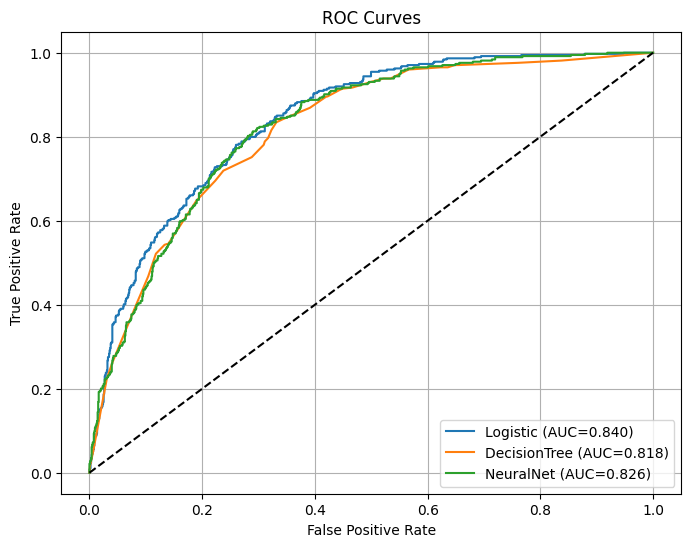

In [26]:
# -----------------------------
# 8. ROC Curves
# -----------------------------
plt.figure(figsize=(8,6))
for name, y_proba in [("Logistic", log_proba), ("DecisionTree", dt_proba), ("NeuralNet", nn_proba)]:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(True)
plt.show()

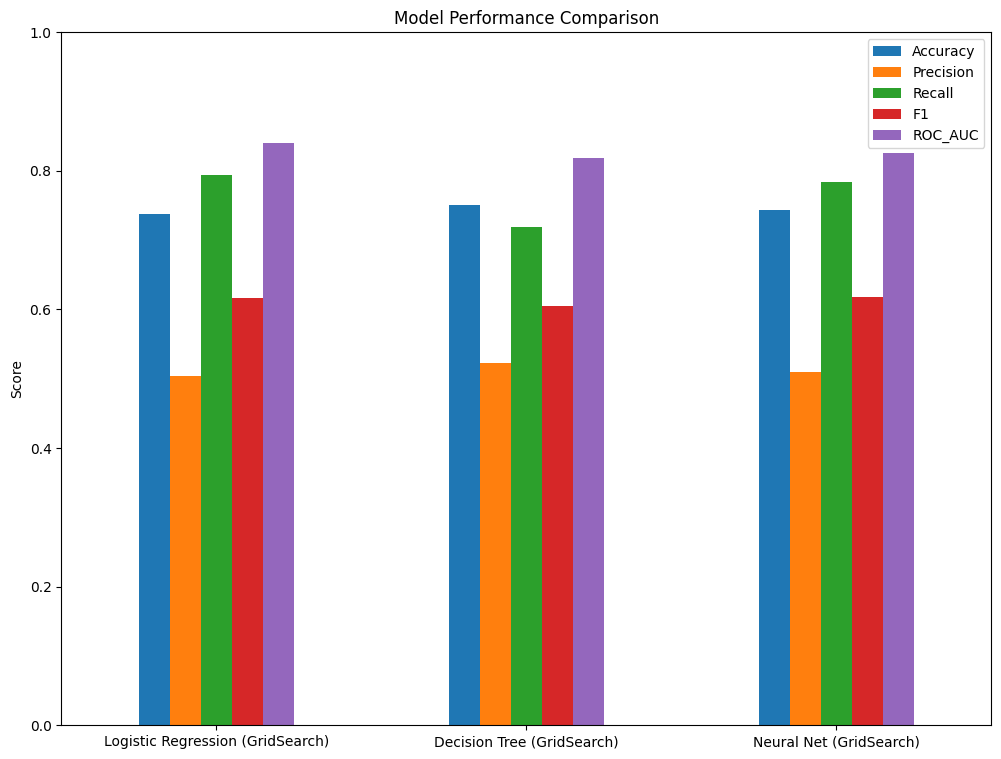

In [34]:
# -----------------------------
# 9. Metrics Comparison Barplot
# -----------------------------
metrics_df = pd.DataFrame(metrics_summary, index=["Accuracy","Precision","Recall","F1","ROC_AUC"]).T
metrics_df.plot(kind="bar", figsize=(12,9))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="upper right")
plt.ylim(0,1)
plt.show()